In [5]:

!pip install --upgrade google-cloud


  Using cached google_cloud-0.34.0-py2.py3-none-any.whl.metadata (2.7 kB)
Using cached google_cloud-0.34.0-py2.py3-none-any.whl (1.8 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [6]:
!pip install db_dtypes


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install google-cloud-bigquery

!gcloud --version

  Using cached google_cloud_bigquery-3.31.0-py3-none-any.whl.metadata (7.7 kB)
  Using cached google_api_core-2.24.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached google_cloud_core-2.4.3-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached protobuf-6.30.2-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
Using cached google_cloud_bigquery-3.31.0-py3-none-any.whl (250 kB)
Using cached google_api_core-2.24.2-py3-none-any.whl (160 kB)
Using cached google_cloud_core-2.4.3-py2.py3-none-any.whl (29 kB)
Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl (81 kB)
Using cached packaging-25.0-py3-none-any.whl (66 kB)
Using cached ca

In [ ]:
!gcloud auth list
!gcloud auth application-default login

  Credentialed Accounts
ACTIVE  ACCOUNT
        pg342@cornell.edu

To set the active account, run:
    $ gcloud config set account `ACCOUNT`



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=I6zc606PnWTExg0MotJAYDLJ44Y8A0&access_type=offline&code_challenge=8E_iIaWD33paAcVUoNN5CaOSpGZxzsVjX310LmKmTH4&code_challenge_method=S256


Credentials saved to file: [/Users/pranavigupta/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Applicati

In [2]:
project_name = "data-project-455021"

mimic3_v1_4


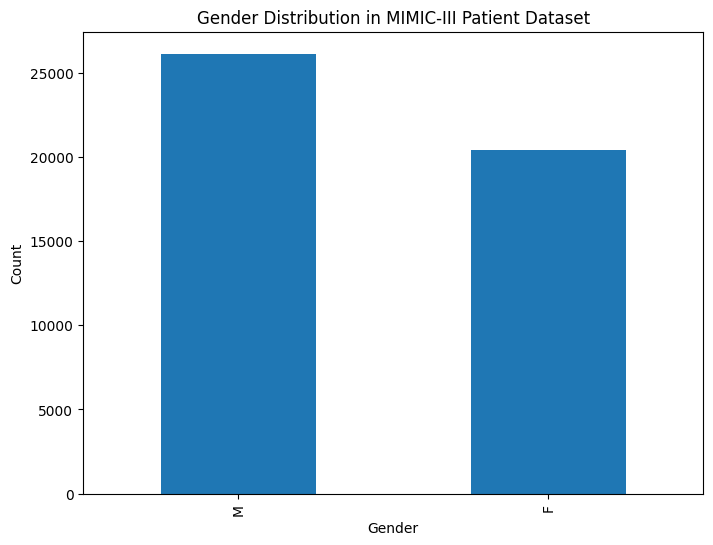

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import db_dtypes as db_dtypes

client = bigquery.Client(project=project_name)

# List datasets in the specified project
datasets = list(client.list_datasets())

# Print the dataset names
for dataset in datasets:
    print(dataset.dataset_id)

# TODO(developer): Set table_id to the ID of the destination table.
# table_id = "your-project.your_dataset.your_table_name"
sql = f'SELECT * FROM `{project_name}.mimic3_v1_4.PATIENTS`'
query_job = client.query(sql)

# df = query_job.to_dataframe()
rows = query_job.result()
patients_df = pd.DataFrame([dict(row) for row in rows])

plt.figure(figsize=(8, 6))
patients_df['GENDER'].value_counts().plot(kind='bar')

plt.title('Gender Distribution in MIMIC-III Patient Dataset')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

In [ ]:
!pip install bitarray
from bitarray import bitarray
import hashlib
import random
import math
random.seed(0)

class BloomFilter(object):
    def __init__(self, size, hash_count):
        """
        size: size of bit array
        hash_count: number of hash functions to use
        """
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.hash_param = []
        i=0
        while i<hash_count:
            a=random.randint(1,9999)
            b=random.randint(1,9999)
            p = self.generate_large_prime(30)
            self.hash_param.append((a,b,p))
            i+=1
            
    def generate_large_prime(self, bit_size):

        random_number = random.getrandbits(bit_size)
        
        while not self.is_prime(random_number):
            random_number = random.getrandbits(bit_size)
        return random_number

    def is_prime(self, number):
        if number % 2 == 0:
            return False


        for i in range(3, int(math.sqrt(number)) + 1, 2):
            if number % i == 0:
                return False

        return True
    def calculate_hash(self,item,hash_params):
        item_val = (hash_params[0]*item + hash_params[1])%hash_params[2]
        #print (item_val,hash_params[2])
        return item_val
    
    
    def add(self, item):
        """
        Add an item to the filter
        """
        for p in self.hash_param:
            self.bit_array[self.calculate_hash(item, p)% self.size] = 1
        
    def lookup(self, item):
        """
        Check for existence of an item in filter
        """

        for p in self.hash_param:
            if self.bit_array[self.calculate_hash(item, p)% self.size] == 0:
                return False
        
        return True

In [38]:
# SQL query to join the admissions table with the diagnoses table
sql = f"""
SELECT
    a.SUBJECT_ID,
    a.HADM_ID,
    d.ICD9_CODE,
    a.ADMITTIME
FROM
    `{project_name}.mimic3_v1_4.ADMISSIONS` as a
LEFT JOIN
    `{project_name}.mimic3_v1_4.DIAGNOSES_ICD` as d
ON
    a.SUBJECT_ID = d.SUBJECT_ID AND a.HADM_ID = d.HADM_ID
"""
query_job = client.query(sql)
rows = query_job.result()

diagnoses_df = pd.DataFrame([dict(row) for row in rows])

diagnoses_df['DIAGNOSIS_FLAG'] = diagnoses_df['ICD9_CODE'].notnull()

# Left join because want to keep all admissions to the hospital, and add false to flag if no diagnosis was given

ground_truth_df = diagnoses_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ICD9_CODE', 'DIAGNOSIS_FLAG']]

ground_truth_df['DIAGNOSIS_FLAG'].fillna(False, inplace=True)
print("Ground Truth DataFrame:", len(ground_truth_df))
print(ground_truth_df.head(5))

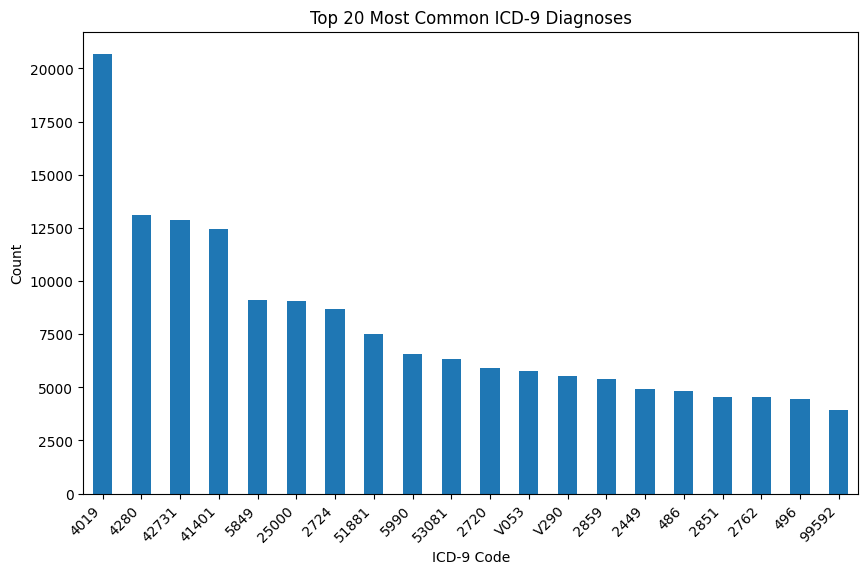

In [35]:
# Count the occurrences of each ICD9_CODE
icd9_counts = diagnoses_df['ICD9_CODE'].value_counts()

plt.figure(figsize=(10, 6))
icd9_counts.head(20).plot(kind='bar')

plt.title('Top 20 Most Common ICD-9 Diagnoses')
plt.xlabel('ICD-9 Code')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.show()

In [39]:
icd_d_sql = f'SELECT * FROM `{project_name}.mimic3_v1_4.D_ICD_DIAGNOSES`'
icd_df_job = client.query(icd_d_sql)
icd_df_rows = icd_df_job.result()
icd_df = pd.DataFrame([dict(row) for row in icd_df_rows])
icd_df = icd_df.dropna(how='all')

ground_truth_df = pd.merge(diagnoses_df, icd_df, on=['ICD9_CODE'], how='left')
print(ground_truth_df.head(5))

icd9_counts = ground_truth_df['SHORT_TITLE'].value_counts()

plt.figure(figsize=(10, 6))
icd9_counts.head(20).plot(kind='bar')

plt.title('Top 20 Most Common ICD-9 Diagnoses')
plt.xlabel('ICD-9 Code')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:

patients_df = patients_df.dropna(how='all')
admissions_sql = f'SELECT * FROM `{project_name}.mimic3_v1_4.ADMISSIONS`'
admissions_query_job = client.query(admissions_sql)
admissions_rows = admissions_query_job.result()
admissions_df = pd.DataFrame([dict(row) for row in admissions_rows])
admissions_df = admissions_df.dropna(how='all')
print(admissions_df['SUBJECT_ID'].isin(patients_df['SUBJECT_ID']).all())  # True means filtering is unnecessary

In [ ]:
# Bloom Filter Testing

bloom_filter = BloomFilter(size=100000, hash_count=5)

for subject_id in patients_df['SUBJECT_ID']:
    bloom_filter.add(subject_id)

filtered_admissions_df = admissions_df[admissions_df['SUBJECT_ID'].apply(
    lambda x: bloom_filter.lookup(x))]

result_df = pd.merge(patients_df, filtered_admissions_df, on='SUBJECT_ID', how='inner')

print("Patients DataFrame length", len(patients_df))
print("Admissions DataFrame length", len(admissions_df))
print("Filtered DataFrame length", len(filtered_admissions_df))
print("Patient-Admissions DataFrame length", len(result_df))

In [ ]:
#Bloom Filter Testing with Diagnoses Table
diagnoses_sql = f"SELECT * FROM `{project_name}.mimic3_v1_4.DIAGNOSES_ICD`"
diagnoses = client.query(diagnoses_sql)
diagnoses_rows = diagnoses.result()
diagnoses_icd_df = pd.DataFrame([dict(row) for row in diagnoses_rows])
print(admissions_df['SUBJECT_ID'].isin(diagnoses_icd_df['SUBJECT_ID']).all())  # True means filtering is unnecessary
print(patients_df['SUBJECT_ID'].isin(diagnoses_icd_df['SUBJECT_ID']).all())  # True means filtering is unnecessary
diagnoses_icd_df = diagnoses_icd_df.dropna(how='all')

print("Diagnoses DataFrame length", len(diagnoses_icd_df))
print("Patient-Admissions DataFrame length", len(result_df))

filtered_admissions_df = diagnoses_icd_df[diagnoses_icd_df['SUBJECT_ID'].apply(
    lambda x: bloom_filter.lookup(x))]

print("Filtered Admissions DataFrame length", len(filtered_admissions_df))
result_df = pd.merge(patients_df, diagnoses_icd_df, on='SUBJECT_ID', how='inner')

print("Patient-Admissions-Diagnoses DataFrame length", len(result_df))

In [32]:
labeevents_sql = f"""
SELECT SUBJECT_ID, HADM_ID, ITEMID, VALUE, VALUEUOM, FLAG  
FROM `{project_name}.mimic3_v1_4.LABEVENTS`  
WHERE ITEMID IN (50983, 50971, 50912, 51006, 50907, 50909, 50906, 50954, 51000, 50960, 50902, 50809, 50910, 50970, 50893, 51274, 51237, 50882)  
AND DATE(CHARTTIME) >= DATE_SUB(CURRENT_DATE(), INTERVAL 1 YEAR)
AND RAND() <= 0.1;
"""
labeevents_job = client.query(labeevents_sql)
labeevents_rows = labeevents_job.result()
labeevents_df = pd.DataFrame([dict(row) for row in labeevents_rows])
labeevents_df = labeevents_df.dropna(how='all')

In [33]:
diagnoses_sql = f'SELECT * FROM `{project_name}.mimic3_v1_4.DIAGNOSES_ICD`'
diag_job = client.query(diagnoses_sql)
diag_rows = diag_job.result()
diag_df = pd.DataFrame([dict(row) for row in diag_rows])
diag_df = diag_df.dropna(how='all')

In [ ]:
#medical history experimentation
medical_history_df = diagnoses_df.merge(admissions_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME']], on=['SUBJECT_ID', 'HADM_ID'])
medical_history_df['ADMITTIME'] = pd.to_datetime(medical_history_df['ADMITTIME'])

#we want to only count the number of past diagnoses for each patient
medical_history_df = medical_history_df.groupby('SUBJECT_ID').apply(
    lambda group: group[group['ADMITTIME'] < group['ADMITTIME'].max()]
).reset_index(drop=True)

past_diagnoses_count = medical_history_df.groupby('SUBJECT_ID')['ICD9_CODE'].nunique().reset_index()
past_diagnoses_count.rename(columns={'ICD9_CODE': 'TOTAL_PAST_DIAGNOSES'}, inplace=True)

# if there were no previous diagnoses, change the NA to 0
patients_medical_df = pd.merge(result_df, past_diagnoses_count, on='SUBJECT_ID', how='left')
patients_medical_df['TOTAL_PAST_DIAGNOSES'].fillna(0, inplace=True) 

# add in lab events
feature_df = pd.merge(patients_medical_df, labeevents_df[['HADM_ID', 'ITEMID', 'VALUE']], 
                            on='HADM_ID', how='left')


#final joined dataset for feature analysis
feature_df.head()

In [ ]:
!pip install openai
import os
import openai
from openai import OpenAI

api_key_ai = os.getenv('OPENAI_API_KEY')
openai.api_key = api_key_ai

In [ ]:
import pandas as pd
import time

# Set your API key
openai.api_key = "Enter your OpenAI API key here"

# Simple function to create a prompt from patient data
def get_prompt(row):
    prompt = f"""
    Patient information:
    - Age: {row.get('AGE', 'Unknown')}
    - Gender: {row.get('GENDER', 'Unknown')}
    - Past diagnoses: {int(row['TOTAL_PAST_DIAGNOSES'])}
    - Death Flag: {'Yes' if row.get('DOD', None) is not None else 'No'}
    
    Lab results:
    """
    
    # can use itemid if that is provided
    if 'ITEMID' in row and 'VALUE' in row:
        prompt += f"- Lab {row['ITEMID']}: {row['VALUE']}\n"
    
    prompt += "\nWhat is the most likely diagnosis? Include ICD9 code."
    return prompt

def get_diagnosis(prompt):
    response = openai.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a medical expert. Provide diagnoses with ICD9 codes."},
            {"role": "user", "content": prompt}
        ],
    )
    return response.choices[0].message.content

# Sample a few rows to test
sample = feature_df.sample(3)
results = []

for _, row in sample.iterrows():
    prompt = get_prompt(row)
    
    diagnosis = get_diagnosis(prompt)
    results.append({
        'HADM_ID': row.get('HADM_ID', 'Unknown'),
        'predicted_diagnosis': diagnosis
    })

results_df = pd.DataFrame(results)
print(results_df)

In [27]:
pd.set_option('display.max_colwidth', None)
print(results_df['predicted_diagnosis'])

In [ ]:
patient_id = 249

note_events_sql = f"""
SELECT SUBJECT_ID, HADM_ID, DESCRIPTION, ISERROR, TEXT, CHARTDATE
FROM (
  SELECT *, ROW_NUMBER() OVER (PARTITION BY SUBJECT_ID ORDER BY CHARTDATE DESC) AS rn
  FROM `{project_name}.mimic3_v1_4.NOTEEVENTS`
  WHERE SUBJECT_ID = {patient_id}
)
WHERE rn = 1
"""

single_note_job = client.query(note_events_sql)
single_note_rows = single_note_job.result()
single_note_df = pd.DataFrame([dict(row) for row in single_note_rows])
single_note_df = single_note_df.dropna(how='all')
print(single_note_df.head(5))
print(len(single_note_df))
print(single_note_df['TEXT'].iloc[0])

In [40]:
note_events_sql = f"""
SELECT SUBJECT_ID, HADM_ID, DESCRIPTION, ISERROR, TEXT, CHARTDATE
FROM (
  SELECT *, ROW_NUMBER() OVER (PARTITION BY SUBJECT_ID ORDER BY CHARTDATE DESC) AS rn
  FROM `{project_name}.mimic3_v1_4.NOTEEVENTS`
  WHERE HADM_ID IS NOT NULL
)
WHERE rn = 1
"""

note_job = client.query(note_events_sql)
note_rows = note_job.result()
note_df = pd.DataFrame([dict(row) for row in note_rows])
note_df = note_df.dropna(how='all')
print(note_df.head(5))
print(len(note_df))
print(note_df['TEXT'].iloc[0])

In [41]:
note_df_small = note_df[['SUBJECT_ID', 'HADM_ID', 'TEXT']]

diag_df = ground_truth_df[['SUBJECT_ID', 'HADM_ID', 'SHORT_TITLE']]

diag_grouped = (
    diag_df
    .groupby(['SUBJECT_ID', 'HADM_ID'])['SHORT_TITLE']
    .apply(list)
    .reset_index()
)

test_ground_truth = pd.merge(
    note_df_small,
    diag_grouped,
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

print(test_ground_truth.head())
print(f"Final merged dataset size: {len(test_ground_truth)}")

one_diagnosis = test_ground_truth
one_diagnosis['PRIMARY_DIAGNOSIS'] = one_diagnosis['SHORT_TITLE'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
print(one_diagnosis.head())

   SUBJECT_ID  HADM_ID                                               TEXT  \
0         114   178393  Admission Date:  [**2146-8-29**]       Dischar...   
1         239   127976  Admission Date:  [**2175-1-12**]              ...   
2         346   195392  Admission Date:  [**2149-11-29**]             ...   
3         429   194060  Admission Date:  [**2163-8-24**]       Dischar...   
4         557   196363  Sinus bradycardia. Probable old inferior wall ...   

                                         SHORT_TITLE  
0  [Crnry athrscl natve vssl, Intermed coronary s...  
1  [Crnry athrscl natve vssl, Chronic kidney dis ...  
2  [Pneumonia, organism NOS, Atrial fibrillation,...  
3  [Aortic valve disorder, Urin tract infection N...  
4  [AMI anterior wall, init, Atrial fibrillation,...  
Final merged dataset size: 46139
   SUBJECT_ID  HADM_ID                                               TEXT  \
0         114   178393  Admission Date:  [**2146-8-29**]       Dischar...   
1         239   1279

In [43]:
import csv

filename = 'new_patient_notes.csv'
header = ['patient_id', 'notes']
rows = note_df[['SUBJECT_ID', 'TEXT']].values.tolist()

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    csvwriter.writerow(header)
    csvwriter.writerows(rows)

print(f"Created CSV file: {filename}")

Created CSV file: new_patient_notes.csv


In [44]:
print("Number of entries in CSV file", len(rows))

In [45]:
#Checking that all subject ids from notes_df are also in the ground truth

ids_ground_truth = set(test_ground_truth['SUBJECT_ID'])
ids_notes = set(note_df['SUBJECT_ID'])

missing_subject_ids = ids_ground_truth - ids_notes

print("Missing Patients", missing_subject_ids, len(missing_subject_ids))


In [47]:
import csv 

filename = 'new_ground_truth.csv'
header = ['patient_id', 'diagnosis']
rows = test_ground_truth[['SUBJECT_ID', 'SHORT_TITLE']].values.tolist()

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    csvwriter.writerow(header)
    csvwriter.writerows(rows)

print(f"Created CSV file: {filename}")

Created CSV file: new_ground_truth.csv


In [48]:
import csv 

filename = 'new_primary_diagnosis.csv'
header = ['patient_id', 'diagnosis']
rows = one_diagnosis[['SUBJECT_ID', 'PRIMARY_DIAGNOSIS']].values.tolist()

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    csvwriter.writerow(header)
    csvwriter.writerows(rows)

print(f"Created CSV file: {filename}")

Created CSV file: new_primary_diagnosis.csv


In [ ]:
import pandas as pd
import re

# Load the CSV file
df = pd.read_csv("patient_notes.csv")

# Based on the pattern tests, implement the corrected extraction
# Helper function for safer extraction with better whitespace handling
def safe_extract(text, pattern, flags=re.IGNORECASE, default=None):
    if pd.isna(text):
        return default
    match = re.search(pattern, text, flags=flags)
    if match:
        return match.group(1).strip()
    return default

# Helper function for multi-line extraction with improved pattern handling
def extract_section(text, pattern, flags=re.IGNORECASE|re.DOTALL, default=None):
    if pd.isna(text):
        return default
    match = re.search(pattern, text, flags=flags)
    if match:
        result = match.group(1).strip()
        # Clean up whitespace
        result = re.sub(r'\s+', ' ', result)
        return result
    return default

# Extract "Reason:" using exact pattern matching from tests
df["reason_simple"] = df["notes"].apply(
    lambda x: safe_extract(x, r"Reason:[ \t]*([^\n]+)")
)

# Extract "REASON FOR THIS EXAMINATION:" block
df["reason_block"] = df["notes"].apply(
    lambda x: extract_section(x, r"REASON FOR THIS EXAMINATION:[ \t]*\n([\s\S]*?)(?=\n\s*\n|__+)")
)

# Extract "Admitting Diagnosis:"
df["admit_dx"] = df["notes"].apply(
    lambda x: safe_extract(x, r"Admitting Diagnosis:[ \t]*([^\n]+)", re.IGNORECASE)
)

# Extract PMH section - try both single line and multi-line patterns
df["pmh_section"] = df["notes"].apply(
    lambda x: (
        safe_extract(x, r"PMH:[ \t]*([^\n]+)", re.IGNORECASE) or 
        extract_section(x, r"PMH:[ \t]*\n([\s\S]*?)(?=\n\s*\n|\n[A-Z])", re.IGNORECASE|re.DOTALL)
    )
)

# Extract INDICATION
df["indication"] = df["notes"].apply(
    lambda x: extract_section(x, r"INDICATION:[ \t]*\n?([\s\S]*?)(?=\n\s*\n|TECHNIQUE|COMPARISON)", re.IGNORECASE|re.DOTALL)
)

# Find all H/O history items
df["history_list"] = df["notes"].apply(
    lambda x: re.findall(r"H/O\s+([^,;\.\n]+)", x, flags=re.IGNORECASE) if not pd.isna(x) else []
)

# Also find history of/hx of patterns
history_of_lists = df["notes"].apply(
    lambda x: re.findall(r"(?:history of|hx of)\s+([^,;\.\n]+)", x, flags=re.IGNORECASE) if not pd.isna(x) else []
)

# Combine history lists safely
for i in range(len(df)):
    if isinstance(df.at[i, "history_list"], list) and isinstance(history_of_lists[i], list):
        df.at[i, "history_list"].extend(history_of_lists[i])

# Extract additional history sections
df["additional_history"] = df["notes"].apply(
    lambda x: extract_section(x, r"Additional history:[ \t]*\n?([\s\S]*?)(?=\n\s*\n|\n[A-Z])", re.IGNORECASE|re.DOTALL)
)

# Create the DataFrame with the extracted information
important = df[[
    "patient_id",
    "reason_simple", 
    "reason_block",
    "admit_dx",
    "history_list",
    "pmh_section",
    "indication",
    "additional_history"
]]

# Print extraction results for each record
print("\n=== DETAILED EXTRACTION RESULTS ===\n")
for i, row in df.iterrows():
    print(f"PATIENT ID: {row['patient_id']}")
    print(f"  Reason (simple): {row['reason_simple']}")
    print(f"  Reason block: {row['reason_block']}")
    print(f"  Admitting Dx: {row['admit_dx']}")
    print(f"  History items: {row['history_list']}")
    print(f"  PMH section: {row['pmh_section']}")
    print(f"  Indication: {row['indication']}")
    print(f"  Additional history: {row['additional_history']}")
    print("-" * 80)

# Analyze extraction success rates
print("\n=== EXTRACTION SUCCESS RATES ===\n")
for col in important.columns:
    success_rate = important[col].notna().mean() * 100
    print(f"{col}: {success_rate:.1f}% success")

# Count empty history lists (those will show as not null even if empty)
empty_history_lists = sum(1 for x in important["history_list"] if isinstance(x, list) and len(x) == 0)
if empty_history_lists > 0:
    print(f"Note: {empty_history_lists} records have empty history_list arrays")

# Save the final extracted information to a CSV file
important.to_csv("extracted_medical_notes.csv", index=False)

print("\nExtraction completed and results saved to 'extracted_medical_notes.csv'")
